In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

Q  10종 분류 데이터를 통한 모델 학습후 성능이 90%정도 나올수있도록 학습시켜주시오


In [ ]:
batch_size=128
tr_data=datasets.CIFAR10(root='./.data/',train=True,download=True,transform=
                              transforms.Compose([
                                  transforms.RandomCrop(32,padding=4),#이미지 자르기
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ]))
tt_data=datasets.CIFAR10(root='./.data/',train=False,download=True,transform=
                              transforms.Compose([
                                  transforms.RandomCrop(32,padding=4),#이미지 자르기
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ]))
tr_l = torch.utils.data.DataLoader(tr_data,batch_size=batch_size,shuffle=True)
tt_l = torch.utils.data.DataLoader(tt_data,batch_size=batch_size,shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 73650623.07it/s]


Extracting ./.data/cifar-10-python.tar.gz to ./.data/
Files already downloaded and verified


In [ ]:
class B_block(nn.Module):
  def __init__(self,in_planes,planes,stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.shortcut=nn.Sequential()

    if stride != 1 or in_planes != planes:
      self.shortcut=nn.Sequential(
          nn.Conv2d(in_planes,planes,kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(planes)
      )
  def forward(self,x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out=F.relu(out)

    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self,n_class=10):
    super().__init__()
    self.in_planes=16

    self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(16)

    self.layer1=self.make_layer(16,2,stride=1)
    self.layer2=self.make_layer(32,2,stride=2)
    self.layer3=self.make_layer(64,2,stride=2)
    self.linear = nn.Linear(64,n_class)

  def make_layer(self,planes,n_block,stride):
    strides = [stride]+[1]*(n_block-1)
    layers=[]
    for i in strides:
      layers.append(B_block(self.in_planes,planes,i))
      self.in_planes=planes
    return nn.Sequential(*layers)

  def forward(self,x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out,8)
    out = out.view(out.size(0),-1)
    out = self.linear(out)
    return out

In [ ]:
m=ResNet().to(DEVICE)
op = optim.SGD(m.parameters(),lr=0.1,momentum=0.9)
sc = optim.lr_scheduler.StepLR(op,step_size=50,gamma=0.1)

In [ ]:
def train(m,tr_l,op,ep):
  m.train()
  for idx,(x,y) in enumerate(tr_l):
    x,y=x.to(DEVICE),y.to(DEVICE)
    op.zero_grad()
    py=m(x)
    loss=F.cross_entropy(py,y)
    loss.backward()
    op.step()

    if idx%100==0:
      print(f'{ep}회 [{idx*len(x)}/{len(tr_l.dataset)}] loss:{loss.item()}')

def el(m,tt_l):
  m.eval()
  tt_loss=0
  ck_n=0
  with torch.no_grad():
    for x,y in tt_l:
      #데이터 환경 부여
      x,y=x.to(DEVICE),y.to(DEVICE)
      py=m(x)
      tt_loss += F.cross_entropy(py,y,reduction='sum').item()
      pr = py.max(1,keepdim=True)[1]
      ck_n += pr.eq(y.view_as(pr)).sum().item()
  tt_loss /= len(tt_l.dataset)
  tt_acc = 100.*ck_n /len(tt_l.dataset)
  return tt_loss,tt_acc

In [ ]:
for ep in range(1,301):
  sc.step()
  train(m,tr_l,op,ep)
  tt_loss,tt_acc = el(m,tt_l)
  print(f'[{ep}] loss:{tt_loss}, acc:{tt_acc}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
tr_data=datasets.FashionMNIST(
  root='/.data/',
  train=True,
  download=True,
  transform=transforms.ToTensor()
)
tr_l=torch.utils.data.DataLoader(
    dataset=tr_data,
    batch_size=64,
    shuffle=True
)

In [ ]:
class Auto_E(nn.Module):
  def __init__(self):
    super().__init__()

    self.e_c_m=nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3),
    )
    self.de_c_m=nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid(),
    )
  def forward(self,x):
    ec_d=self.e_c_m(x)
    de_d=self.de_c_m(ec_d)
    return ec_d,de_d


In [ ]:
auto_e=Auto_E().to(DEVICE)
op=torch.optim.Adam(auto_e.parameters(),lr=0.005)
loss_f=nn.MSELoss()

In [ ]:
v_data = tr_data.data[:5].view(-1,28*28)
v_data = v_data.type(torch.FloatTensor)/255.

In [ ]:
def train(m,tr_l):
  m.train()
  for i, (x,label) in enumerate(tr_l):
    x=x.view(-1,28*28).to(DEVICE)
    y=x.view(-1,28*28).to(DEVICE)
    label = label.to(DEVICE)
    ec_d,de_d = auto_e(x)
    loss = loss_f(de_d,y)
    op.zero_grad()
    loss.backward()
    op.step()

54


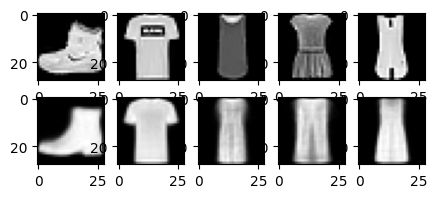

0


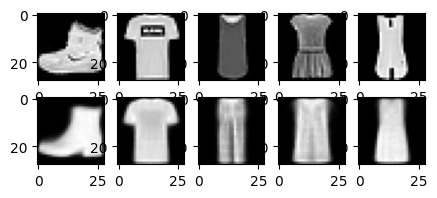

1


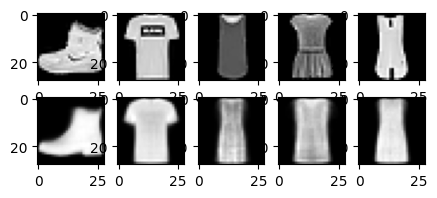

2


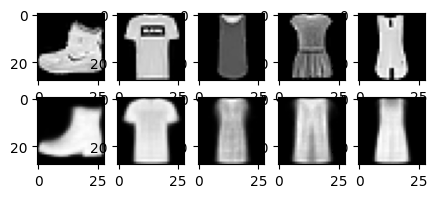

3


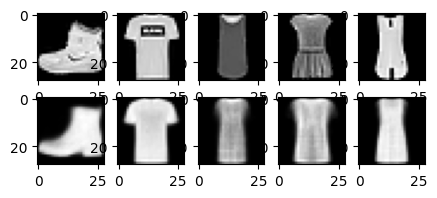

4


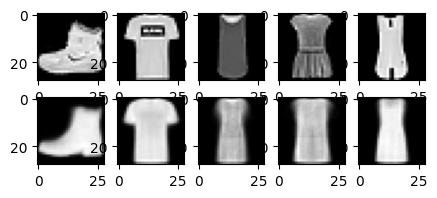

5


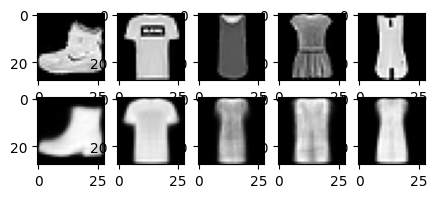

6


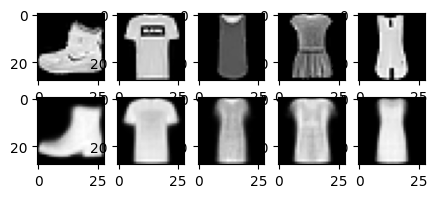

7


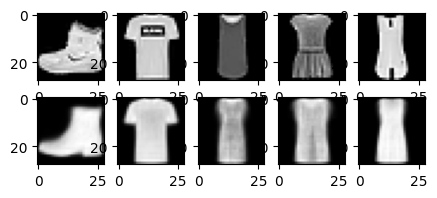

8


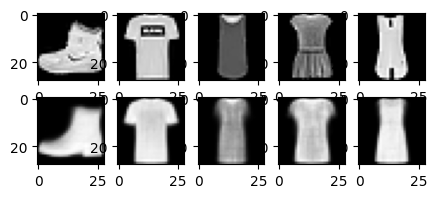

9


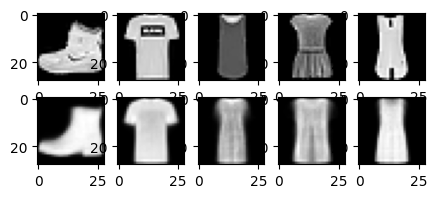

In [ ]:
import matplotlib.pyplot as plt
test_x=v_data.to(DEVICE)
_,out_img=auto_e(test_x)

f,ax=plt.subplots(2,5,figsize=(5,2))
print(f"{ep-1}")
for i in range(5):
  img =  v_data.data.numpy()[i].reshape(28,28)
  ax[0][i].imshow(img,cmap='gray')
for i in range(5):
  img =  out_img.data.numpy()[i].reshape(28,28)
  ax[1][i].imshow(img,cmap='gray')
plt.show()
for ep in range(1,11):
  train(auto_e,tr_l)
  test_x=v_data.to(DEVICE)
  _,out_img=auto_e(test_x)

  f,ax=plt.subplots(2,5,figsize=(5,2))
  print(f"{ep-1}")
  for i in range(5):
    img =  v_data.data.numpy()[i].reshape(28,28)
    ax[0][i].imshow(img,cmap='gray')
  for i in range(5):
    img =  out_img.data.numpy()[i].reshape(28,28)
    ax[1][i].imshow(img,cmap='gray')
  plt.show()




In [ ]:
ck_data=tr_data.data[:100].view(-1,28*28)
ck_data = ck_data.type(torch.FloatTensor)/255.
label=tr_data.targets[:100].numpy()

In [ ]:
out_d=ck_data.to(DEVICE)
ec_d,_=auto_e(out_d)
x=ec_d.data[:,0].numpy()
y=ec_d.data[:,1].numpy()
z=ec_d.data[:,2].numpy()

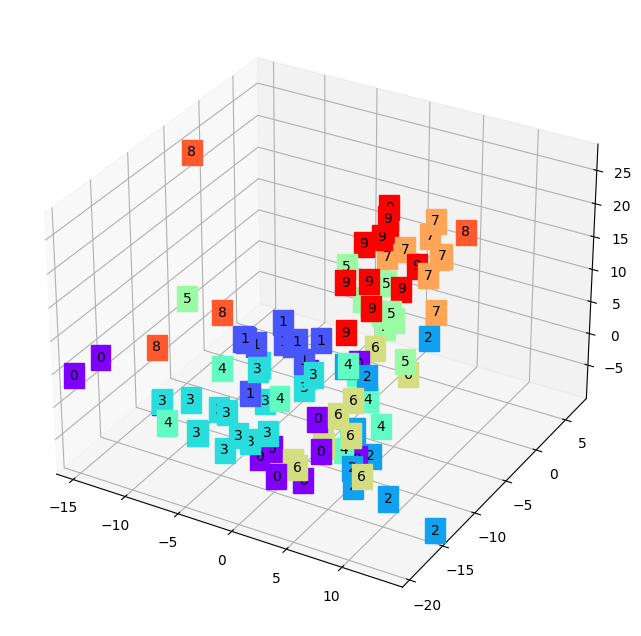

In [ ]:
import matplotlib as mp
f=plt.figure(figsize=(10,8))
ax = f.add_subplot(111, projection='3d')
for xa,ya,za,l in zip(x,y,z,label):
  lb=str(l)
  c=mp.cm.rainbow(int(255*l/9))
  ax.text(xa,ya,za,lb,backgroundcolor=c)
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_zlim(z.min(),z.max())
plt.show()